### Package

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, metrics, decomposition

### Preprocessing:

##### Select all sensors in Taiwan

In [43]:
df = pd.DataFrame(pd.read_csv('201703_Taiwan_preprocessed.csv',index_col=0))
#Only in Taiwan
df_taiwan = df[(df[' lon'] < 122) & (df[' lon'] > 120) & (df[' lat'] > 22) & (df[' lat'] <25)]
df_taiwan.head()

,device_id,lat,lon,date_time,PM2.5,PM10,PM1,Temperature,Humidity,Date,Time
5452,74DA3895E132,22.624,120.356,2017-03-10 00:00:00,52.50,66.50,35.50,26.87,63.0,2017-03-10,00:00:00
5453,74DA3895E132,22.624,120.356,2017-03-10 00:10:00,52.25,66.25,35.25,26.87,63.0,2017-03-10,00:10:00
5454,74DA3895E132,22.624,120.356,2017-03-10 00:20:00,52.00,66.00,35.00,26.87,63.0,2017-03-10,00:20:00
5455,74DA3895E132,22.624,120.356,2017-03-10 00:30:00,52.75,67.00,35.50,26.87,63.0,2017-03-10,00:30:00
5456,74DA3895E132,22.624,120.356,2017-03-10 00:40:00,53.50,68.00,36.00,26.87,63.0,2017-03-10,00:40:00


### Tasks1 - Spatial Clustering
- Use geometric information to do clustering. (i.e. lat and lon)
-   Use two kinds of clustering methods and compare the differences.

### K-means

In [44]:
df_location = df_taiwan[[' lon',' lat']]
df_location = df_location.drop_duplicates() 
df_location.head()

,lon,lat
5452,120.356,22.624
9868,120.739,24.252
14284,120.748,24.196
18694,120.359,22.633
23109,120.644,24.131


##### Use silhouette_score() to decide the number of cluster, and the best value is 1 and the worst value is -1.

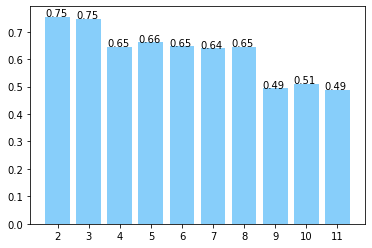

In [45]:
silhouette_avgs = []
ks = range(2, 12)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k, random_state=0).fit(df_location)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(df_location, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

# k = 2 到 10 的績效
plt.bar(ks, silhouette_avgs, facecolor = 'lightskyblue',)
for index, value in enumerate(silhouette_avgs):
    plt.text(ks[index] - 0.4, value + 0.001, str(round(value, 2)))
    
plt.xticks(ks)
plt.show()

#### The best number of cluster is 3, and the worst number is 11


Wall time: 22.9 ms
Wall time: 67.8 ms


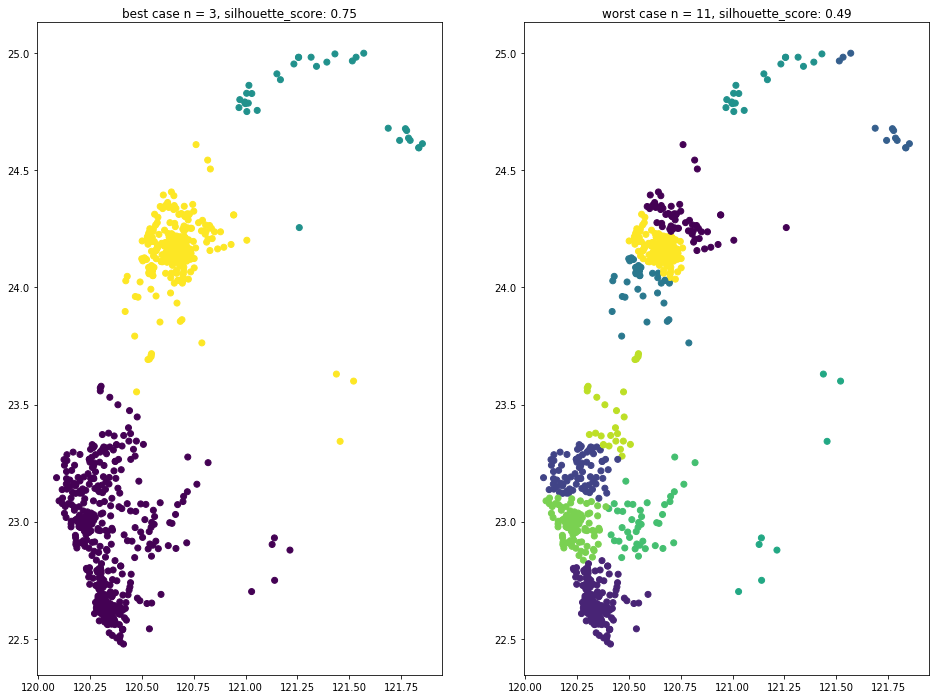

In [46]:
plt.figure(figsize=(16, 12))

kmeans1 = cluster.KMeans(n_clusters = 3, random_state=0)
%time kmeans1.fit(df_location)
silhouette_avg1 = metrics.silhouette_score(df_location, kmeans1.labels_)
plt.subplot(121)
plt.scatter(df_location[' lon'].values, df_location[' lat'].values, c=kmeans1.labels_)
plt.title('best case n = 3, silhouette_score: '+str(round(silhouette_avg1, 2)))

kmeans2 = cluster.KMeans(n_clusters = 11, random_state=0)
%time kmeans2.fit(df_location)
silhouette_avg2 = metrics.silhouette_score(df_location, kmeans2.labels_)

plt.subplot(122)
plt.scatter(df_location[' lon'].values, df_location[' lat'].values, c=kmeans2.labels_)
plt.title('worst case n = 11, silhouette_score: '+str(round(silhouette_avg2, 2)))
plt.show()



### DBSCAN

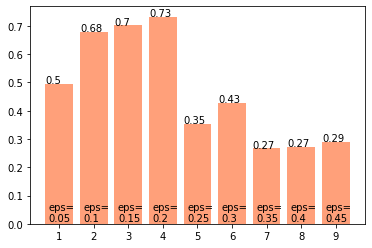

In [47]:
silhouette_avgs = []
ep = range(1, 10)
eps=[]
for e in ep:
    eps.append(e/20)
    DBSCAN_fit = cluster.DBSCAN(eps = float(e/20), min_samples = 10).fit(df_location)
    cluster_labels = DBSCAN_fit.labels_
    silhouette_avg = metrics.silhouette_score(df_location, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

for i in range(len(eps)):
    plt.text(0.7+(i), 0.05,'eps=')
    plt.text(0.7+(i), 0.01,eps[i])

    
plt.bar(ep, silhouette_avgs, facecolor = 'lightsalmon')
for index, value in enumerate(silhouette_avgs):
    plt.text(ep[index] - 0.4, value + 0.001, str(round(value, 2)))
    
plt.xticks(ep)
plt.show()

#### The best eps value for DBSCAN is 0.2, and the worst is 0.4


Wall time: 12 ms
Wall time: 14 ms


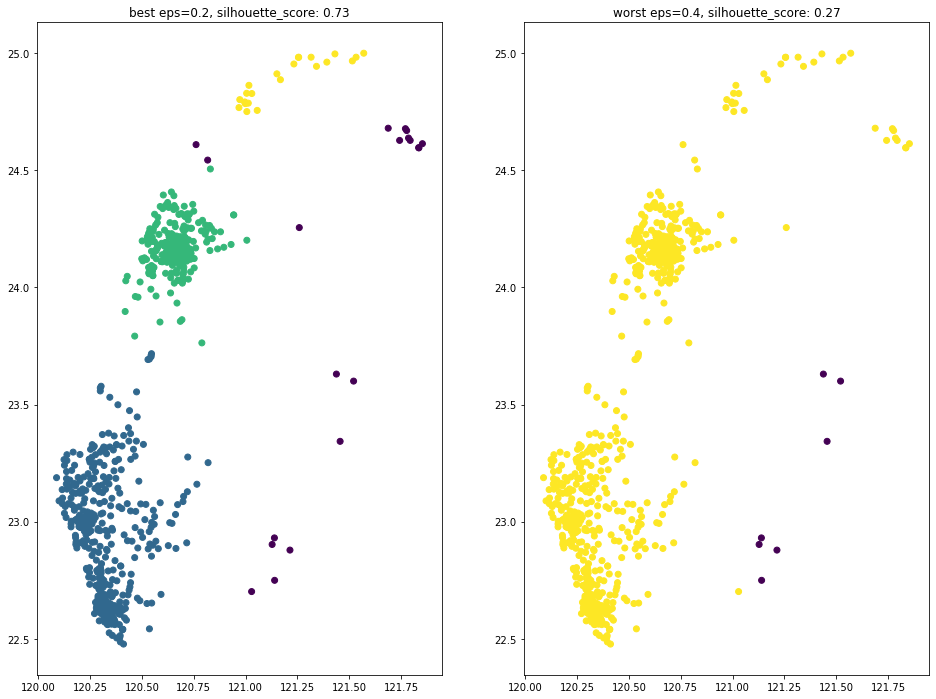

In [48]:
plt.figure(figsize=(16, 12))
DBSCAN1 = cluster.DBSCAN(eps = 0.2, min_samples = 10)
%time DBSCAN1.fit(df_location)
silhouette_avg1 = metrics.silhouette_score(df_location, DBSCAN1.labels_)

plt.subplot(121)
plt.scatter(df_location[' lon'].values, df_location[' lat'].values, c=DBSCAN1.labels_)
plt.title('best eps=0.2, silhouette_score: '+str(round(silhouette_avg1, 2)))

DBSCAN2 = cluster.DBSCAN(eps = 0.4, min_samples = 10)
%time DBSCAN2.fit(df_location)
silhouette_avg2 = metrics.silhouette_score(df_location, DBSCAN2.labels_)

plt.subplot(122)
plt.scatter(df_location[' lon'].values, df_location[' lat'].values, c=DBSCAN2.labels_)
plt.title('worst eps=0.4, silhouette_score: '+str(round(silhouette_avg2, 2)))
plt.show()


###  Tasks2 - Spatial + PM2.5 Clustering:

#### Combine geometric information and PM2.5 data to do clustering with any timestamp (Ex: PM2.5 at 2017/3/10 17:10:00)

In [49]:
df_pm_location = df_taiwan[(df_taiwan['date_time'] == '2017-03-10 17:10:00')]
df_pm_location= df_pm_location[[' lon', ' lat', 'PM2.5']]
df_pm_location.head()

,lon,lat,PM2.5
5555,120.356,22.624,26.5
9971,120.739,24.252,56.5
14387,120.748,24.196,54.0
18797,120.359,22.633,31.0
23212,120.644,24.131,55.0


#### Normalize the data and do clustering again.

$$x_{normalize} = {{x_{old}-x_{min}} \over {x_{max}-x_{min}}}$$

In [50]:
#unity-based normalization [0,1]
df_norm = (df_pm_location-df_pm_location.min())/(df_pm_location.max()-df_pm_location.min())
df_norm.head()

,lon,lat,PM2.5
5555,0.151841,0.057914,0.158065
9971,0.368839,0.703689,0.351613
14387,0.373938,0.681476,0.335484
18797,0.153541,0.061484,0.187097
23212,0.315014,0.655692,0.341935


#### Compare the differences between clustering before normalization and clustering after normalization.

##### before normalization 

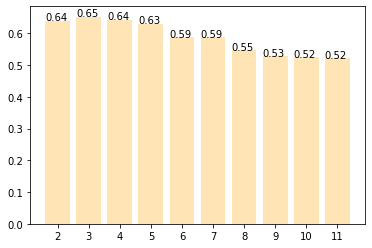

In [51]:
silhouette_avgs = []
ks = range(2, 12)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k, random_state=0).fit(df_pm_location)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(df_pm_location, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

# k = 2 到 10 的績效
plt.bar(ks, silhouette_avgs, facecolor = 'moccasin',)
for index, value in enumerate(silhouette_avgs):
    plt.text(ks[index] - 0.4, value + 0.001, str(round(value, 2)))
    
plt.xticks(ks)
plt.show()

Wall time: 25.5 ms
Wall time: 68.8 ms


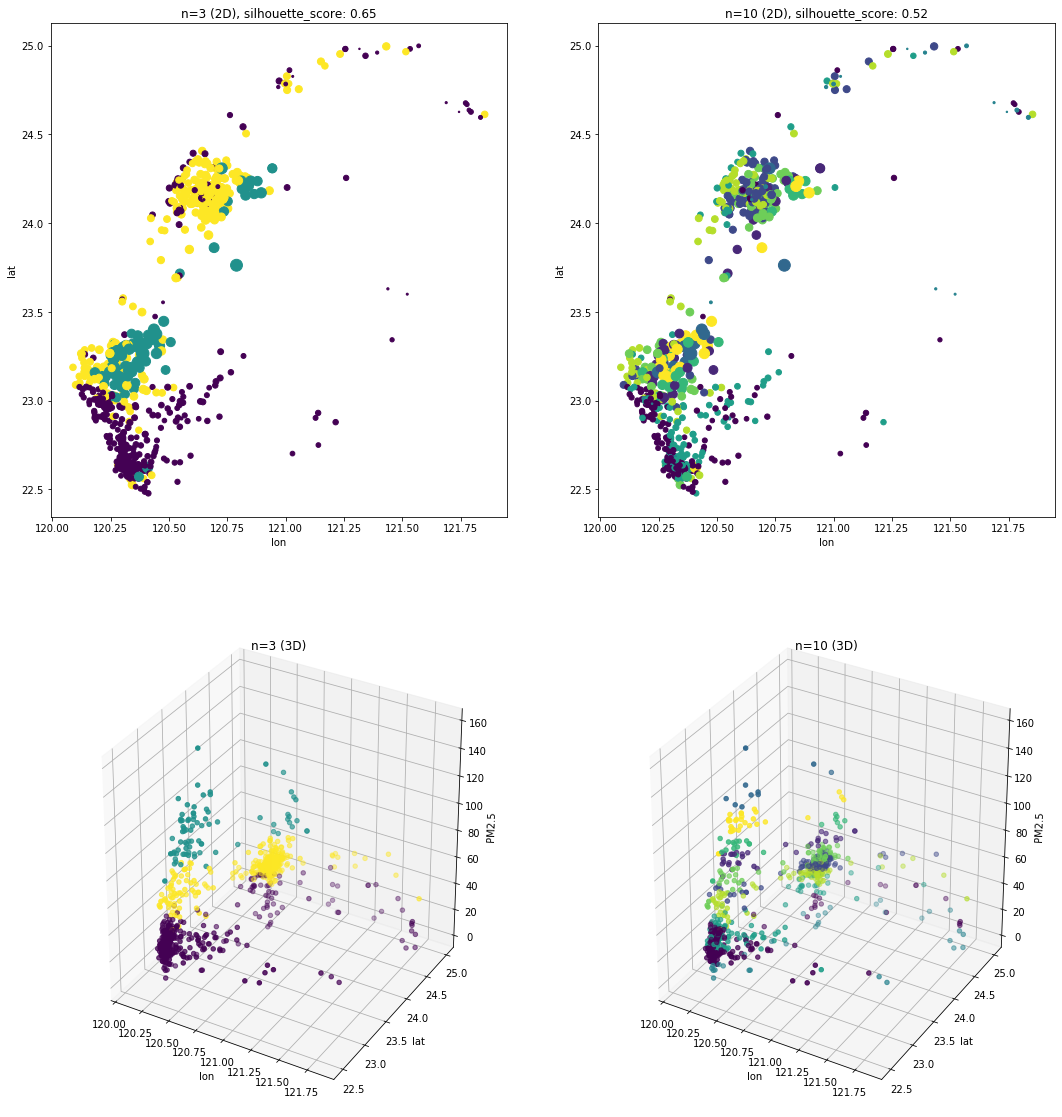

In [52]:
kmeans3 = cluster.KMeans(n_clusters = 3, random_state = 0)
%time kmeans3.fit(df_pm_location)
silhouette_avg1 = metrics.silhouette_score(df_pm_location, kmeans3.labels_)


fig = plt.figure(figsize=(18, 20))

plt.subplot(221)
plt.scatter(df_pm_location[' lon'].values, df_pm_location[' lat'].values, df_pm_location['PM2.5'].values, c=kmeans3.labels_)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('n=3 (2D), silhouette_score: '+str(round(silhouette_avg1, 2)))


ax = fig.add_subplot(223, projection='3d')
ax.scatter(df_pm_location[' lon'].values, df_pm_location[' lat'].values, df_pm_location['PM2.5'].values, c=kmeans3.labels_)
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_zlabel('PM2.5')
plt.title('n=3 (3D)')


kmeans4 = cluster.KMeans(n_clusters = 10, random_state = 0)
%time kmeans4.fit(df_pm_location)
silhouette_avg2 = metrics.silhouette_score(df_pm_location, kmeans4.labels_)


plt.subplot(222)
plt.scatter(df_pm_location[' lon'].values, df_pm_location[' lat'].values, df_pm_location['PM2.5'].values, c=kmeans4.labels_)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('n=10 (2D), silhouette_score: '+str(round(silhouette_avg2, 2)))

ax = fig.add_subplot(224, projection='3d')
ax.scatter(df_pm_location[' lon'].values, df_pm_location[' lat'].values, df_pm_location['PM2.5'].values, c=kmeans4.labels_)
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_zlabel('PM2.5')
plt.title('n=10 (3D)')

plt.show()


#### After normalization

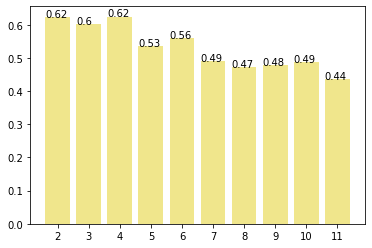

In [53]:
silhouette_avgs = []
ks = range(2, 12)
for k in ks:
    kmeans_fit = cluster.KMeans(n_clusters = k, random_state=1).fit(df_norm )
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(df_norm , cluster_labels)
    silhouette_avgs.append(silhouette_avg)

# k = 2 到 10 的績效
plt.bar(ks, silhouette_avgs, facecolor = 'khaki',)
for index, value in enumerate(silhouette_avgs):
    plt.text(ks[index] - 0.4, value + 0.001, str(round(value, 2)))
    
plt.xticks(ks)
plt.show()

Wall time: 26 ms
Wall time: 85.8 ms


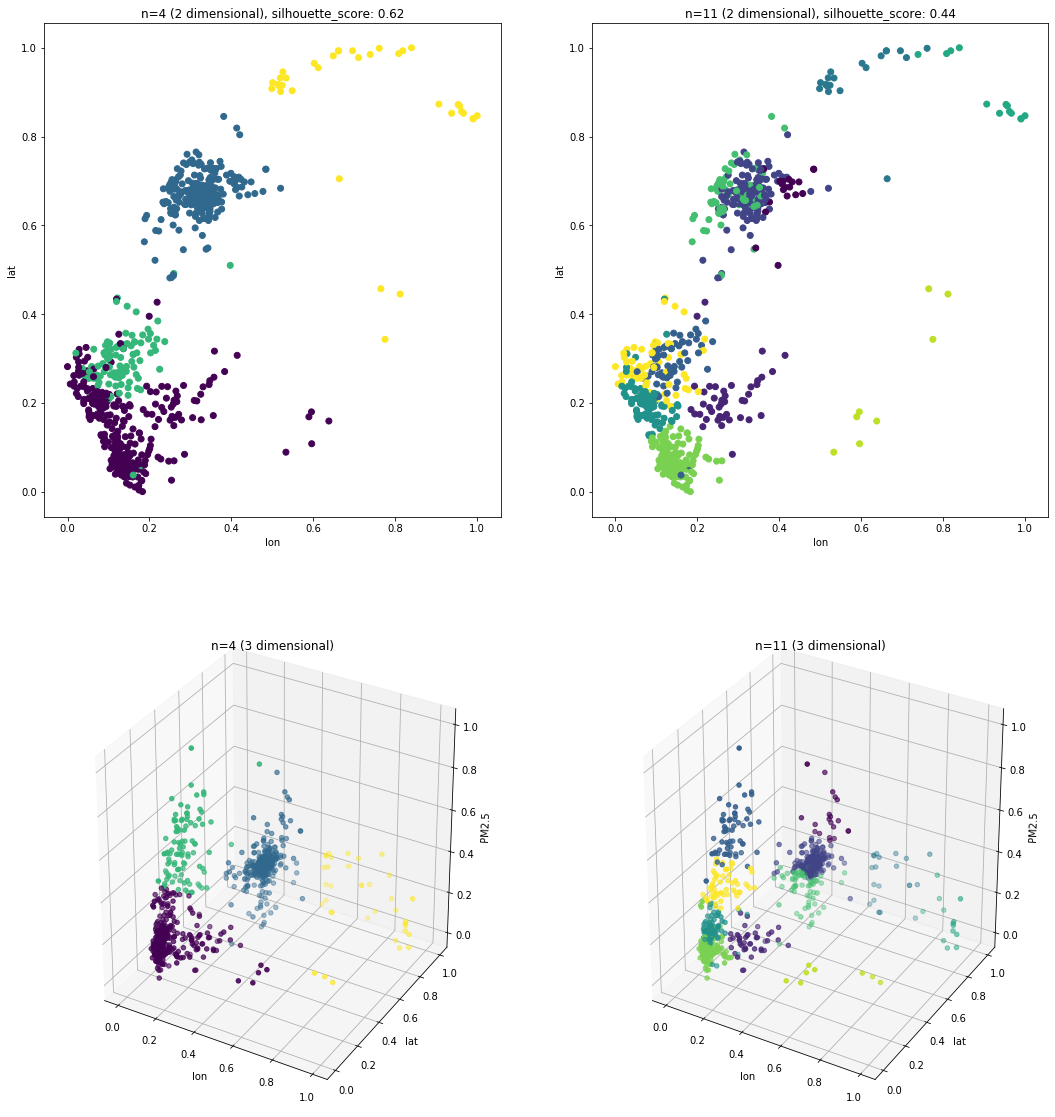

In [54]:
kmeans5 = cluster.KMeans(n_clusters = 4, random_state = 0)
%time kmeans5.fit(df_norm)
silhouette_avg1 = metrics.silhouette_score(df_norm, kmeans5.labels_)



fig = plt.figure(figsize=(18, 20))

plt.subplot(221)
plt.scatter(df_norm[' lon'].values, df_norm[' lat'].values, c=kmeans5.labels_)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('n=4 (2 dimensional), silhouette_score: '+ str(round(silhouette_avg1, 2)))

ax = fig.add_subplot(223, projection='3d')
ax.scatter(df_norm[' lon'].values, df_norm[' lat'].values, df_norm['PM2.5'].values, c=kmeans5.labels_)
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_zlabel('PM2.5')
plt.title('n=4 (3 dimensional)')



kmeans6 = cluster.KMeans(n_clusters = 11, random_state = 0)
%time kmeans6.fit(df_norm)
silhouette_avg2 = metrics.silhouette_score(df_norm, kmeans6.labels_)

plt.subplot(222)
plt.scatter(df_norm[' lon'].values, df_norm[' lat'].values, c=kmeans6.labels_)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('n=11 (2 dimensional), silhouette_score: '+ str(round(silhouette_avg2, 2)))


ax = fig.add_subplot(224, projection='3d')
ax.scatter(df_norm[' lon'].values, df_norm[' lat'].values, df_norm['PM2.5'].values, c=kmeans6.labels_)
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_zlabel('PM2.5')
plt.title('n=11 (3 dimensional)')



plt.show()

###  Tasks3 - Temporal Clustering:


#### Use a static time interval to do clustering.

In [55]:
df_static_time_interval = df_taiwan[(df_taiwan.Date.astype(str)=='2017-03-10' )].iloc[:,[0,1,2,4]]
df_static_time_interval.head()

,device_id,lat,lon,PM2.5
5452,74DA3895E132,22.624,120.356,52.50
5453,74DA3895E132,22.624,120.356,52.25
5454,74DA3895E132,22.624,120.356,52.00
5455,74DA3895E132,22.624,120.356,52.75
5456,74DA3895E132,22.624,120.356,53.50


In [56]:
grouped = df_static_time_interval.groupby('device_id')
df_temporal = pd.DataFrame()

for name, group in grouped:
    if len(group['PM2.5'].tolist())== 144:
        df_temporal[name] = group['PM2.5'].tolist()


In [57]:
df_temporal.reset_index()
df_temporal = df_temporal.T
df_temporal = df_temporal.reset_index()
df_temporal.rename(columns={'index': 'device_id'}, inplace=True)
df_temporal.head()

,device_id,0,1,2,3,4,5,6,7,8,...,134,135,136,137,138,139,140,141,142,143
0,28C2DDDD459E,19.000000,18.500000,18.000000,18.000000,17.0,16.000000,15.000000,14.750000,14.500000,...,30.8,30.0,29.0,28.000000,26.000000,26.000000,25.333333,24.666667,24.000000,22.666667
1,28C2DDDD45E6,29.666667,30.000000,31.000000,36.000000,43.0,42.500000,42.000000,43.000000,44.000000,...,11.0,10.5,10.0,12.000000,15.333333,18.666667,22.000000,26.000000,30.000000,29.000000
2,74DA388FF3AA,17.500000,17.000000,17.000000,17.000000,16.0,15.666667,15.333333,15.000000,17.000000,...,6.0,6.0,6.0,6.000000,6.000000,6.000000,7.000000,8.000000,9.000000,5.000000
3,74DA388FF56C,27.688889,27.666667,27.644444,27.622222,27.6,27.577778,27.555556,27.533333,27.511111,...,10.0,7.0,5.5,4.000000,4.000000,3.500000,3.000000,3.000000,3.000000,3.000000
4,74DA3895C1F8,92.400000,91.000000,92.000000,95.000000,96.0,98.000000,94.000000,93.000000,98.000000,...,38.0,40.5,43.0,43.857143,44.714286,45.571429,46.428571,47.285714,48.142857,49.000000


In [58]:
df4 = df_taiwan[(df_taiwan.Date.astype(str)=='2017-03-10' )].iloc[:,[0,1,2]]
df4.head()

,device_id,lat,lon
5452,74DA3895E132,22.624,120.356
5453,74DA3895E132,22.624,120.356
5454,74DA3895E132,22.624,120.356
5455,74DA3895E132,22.624,120.356
5456,74DA3895E132,22.624,120.356


In [59]:
df_144D = pd.merge(df4, df_temporal, on='device_id')
print('Before removing duplicate rows: ',df_144D.shape[0])
df_144D = df_144D.drop_duplicates()
print('After removing duplicates rows: ',df_144D.shape[0])

Before removing duplicate rows:  112032
After removing duplicates rows:  778


In [60]:
df_144D.head()

,device_id,lat,lon,0,1,2,3,4,5,6,...,134,135,136,137,138,139,140,141,142,143
0,74DA3895E132,22.624,120.356,52.50,52.25,52.00,52.75,53.50,54.250000,55.000000,...,62.0,63.0,64.0,62.0,61.800000,61.600000,61.4,61.2,61.0,60.0
144,74DA3895C590,24.252,120.739,57.75,58.50,59.25,60.00,58.75,57.500000,56.250000,...,35.5,36.0,37.0,38.0,42.000000,41.000000,40.0,38.5,37.0,37.0
288,74DA3895C34E,24.196,120.748,57.00,55.00,53.00,51.00,51.00,49.666667,48.333333,...,37.5,37.0,36.0,37.0,37.000000,37.000000,36.0,36.0,36.0,36.0
432,74DA3895E12A,22.633,120.359,91.00,90.50,90.00,93.00,94.20,95.400000,96.600000,...,92.0,94.0,89.0,83.0,80.666667,78.333333,76.0,73.0,71.5,70.0
576,74DA3895C596,24.131,120.644,85.00,85.50,86.00,86.50,87.00,87.000000,86.000000,...,36.0,38.0,39.5,41.0,43.500000,46.000000,48.0,47.5,47.0,47.0


In [61]:
df_144D.iloc[:,3:-1].head()

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
0,52.50,52.25,52.00,52.75,53.50,54.250000,55.000000,55.5,56.000000,56.000000,...,61.000000,62.0,63.0,64.0,62.0,61.800000,61.600000,61.4,61.2,61.0
144,57.75,58.50,59.25,60.00,58.75,57.500000,56.250000,55.0,53.000000,51.000000,...,35.000000,35.5,36.0,37.0,38.0,42.000000,41.000000,40.0,38.5,37.0
288,57.00,55.00,53.00,51.00,51.00,49.666667,48.333333,47.0,46.666667,46.333333,...,38.000000,37.5,37.0,36.0,37.0,37.000000,37.000000,36.0,36.0,36.0
432,91.00,90.50,90.00,93.00,94.20,95.400000,96.600000,97.8,99.000000,99.000000,...,94.222222,92.0,94.0,89.0,83.0,80.666667,78.333333,76.0,73.0,71.5
576,85.00,85.50,86.00,86.50,87.00,87.000000,86.000000,88.0,87.333333,86.666667,...,32.500000,36.0,38.0,39.5,41.0,43.500000,46.000000,48.0,47.5,47.0


#### Calculate the explained variance to decide n_components for PCA

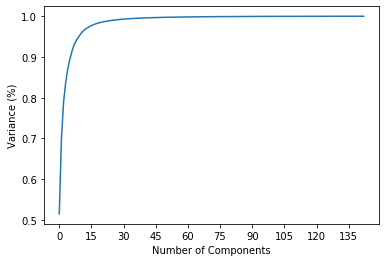

In [62]:
pca = decomposition.PCA().fit(df_144D.iloc[:,3:-1])
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 143, step=15))
plt.ylabel('Variance (%)') #for each component
plt.show()

#### Use PCA to reduce the dimension, and compare the differences between clustering before PCA and clustering

Wall time: 70 ms
Wall time: 24.9 ms


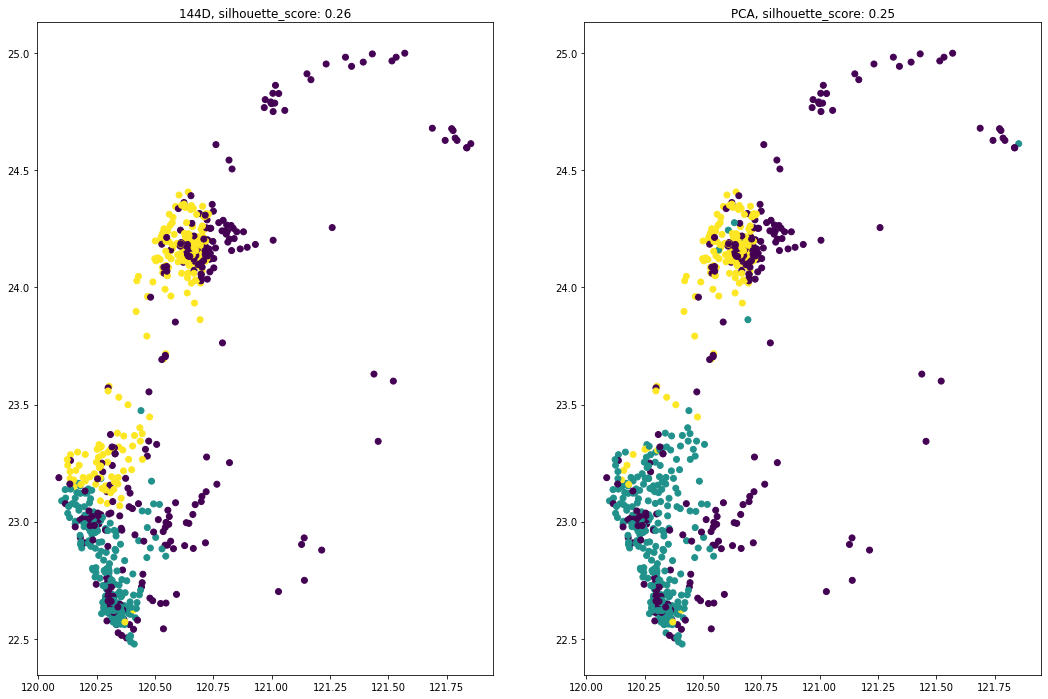

In [63]:

agglo1 = cluster.AgglomerativeClustering(n_clusters=3)
%time agglo1.fit(df_144D.iloc[:,3:-1])
silhouette_avg1 = metrics.silhouette_score(df_144D.iloc[:,3:-1], agglo1.labels_)

agglo2 = cluster.AgglomerativeClustering(n_clusters=3)
reduced_data = decomposition.PCA(n_components=15).fit_transform(df_144D.iloc[:,3:-1])
%time agglo2.fit(reduced_data)
silhouette_avg2 = metrics.silhouette_score(reduced_data, agglo2.labels_)


plt.figure(figsize=(18, 12))

plt.subplot(121)
plt.scatter(df_144D[' lon'], df_144D[' lat'], c=agglo1.labels_)
plt.title('144D, silhouette_score: '+ str(round(silhouette_avg1, 2)))

plt.subplot(122)
labels_pca = agglo1.labels_
plt.scatter(df_144D[' lon'], df_144D[' lat'], c=agglo2.labels_)
plt.title('PCA, silhouette_score: '+ str(round(silhouette_avg2, 2)))
plt.show()
